# Evaluation and analysis

### Setting paths and environment variables:

In [1]:
import os

os.chdir('..')

### Generic:

In [2]:
import os
from pathlib import Path

ROOT = Path(os.path.abspath(''))
DATASET = "Dataset100_MSSEG"
RAW_DATASET_DIR = ROOT / "data" / "nnUNet_raw_data" / DATASET
TEST_IMAGES_DIR = RAW_DATASET_DIR / "imagesTs"
TEST_LABELS_DIR = RAW_DATASET_DIR / "labelsTs"
TERMINATION = ".nii.gz"
PREPROCESSED_DATASET_DIR = ROOT / "data" / "nnUNet_preprocessed_data" / DATASET

In [3]:
os.environ["nnUNet_raw"] = "./data/nnUNet_raw_data"
os.environ["nnUNet_preprocessed"] = "./data/nnUNet_preprocessed_data"
os.environ['nnUNet_results'] = "./nnUNet_results"

### Specific:

In [4]:
DATASET = "Dataset100_MSSEG"
TRAINER = "nnUNetTrainerEarlyStopping"
CONFIGURATION = "3d_fullres"
PLAN = 'nnUNetPlans'


In [5]:
ALL_TEST_PREDICTIONS_FOLDER = os.path.join(ROOT, 'nnUNet_test_results')
specific_folder_name = TRAINER + '__' + PLAN + "__" + CONFIGURATION
TEST_PREDICTIONS_FOLDER = os.path.join(ALL_TEST_PREDICTIONS_FOLDER, DATASET, specific_folder_name)

In [6]:
for var in ["DATASET", "TRAINER", "CONFIGURATION", "PLAN", "TEST_IMAGES_DIR", "TEST_PREDICTIONS_FOLDER"]:
    os.environ[f'nnUNet_{var}'] = str(eval(var))

## Performing the prediction

In [7]:
# !nnUNetv2_predict -d $nnUNet_DATASET -i $nnUNet_TEST_IMAGES_DIR -o $nnUNet_TEST_PREDICTIONS_FOLDER -f  0 1 2 3 4 -tr $nnUNet_TRAINER -c nnUNet_CONFIGURATION -p $nnUNet_PLAN

## Computing results on the folder

In [8]:
from nnunetv2.evaluation.evaluate_predictions import compute_metrics_on_folder_simple, load_summary_json

compute_metrics_on_folder_simple(
    folder_ref=TEST_LABELS_DIR,
    folder_pred=TEST_PREDICTIONS_FOLDER,
    labels=[1, 2]
)

all_results = load_summary_json(filename=os.path.join(TEST_PREDICTIONS_FOLDER, 'summary.json'))

In [9]:
all_results

{'foreground_mean': {'Dice': 0.5976925236957565,
  'FN': 1569.25,
  'FP': 1226.0416666666667,
  'IoU': 0.47306652785763714,
  'TN': 7212432.027777778,
  'TP': 5804.680555555556,
  'n_pred': 7030.722222222223,
  'n_ref': 7373.930555555556},
 'mean': {1: {'Dice': 0.720540349815377,
   'FN': 3117.1666666666665,
   'FP': 2441.5833333333335,
   'IoU': 0.5747683321697162,
   'TN': 7203896.333333333,
   'TP': 11576.916666666666,
   'n_pred': 14018.5,
   'n_ref': 14694.083333333334},
  2: {'Dice': 0.4748446975761361,
   'FN': 21.333333333333332,
   'FP': 10.5,
   'IoU': 0.3713647235455581,
   'TN': 7220967.722222222,
   'TP': 32.44444444444444,
   'n_pred': 42.94444444444444,
   'n_ref': 53.77777777777778}},
 'metric_per_case': [{'metrics': {1: {'Dice': 0.8128637148620604,
     'FN': 3786,
     'FP': 9109,
     'IoU': 0.6847265348035501,
     'TN': 7180131,
     'TP': 28006,
     'n_pred': 37115,
     'n_ref': 31792},
    2: {'Dice': 0.78099173553719,
     'FN': 65,
     'FP': 41,
     'IoU': 

## Confusion matrix:

In [10]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
test_images = os.listdir(TEST_IMAGES_DIR)
test_ids = sorted({file_name.split(".")[0][:-5] for file_name in test_images})

In [12]:
def get_paths(case_id: str, basal_im: bool = False, follow_up_im: bool = False, labels: bool = False,
              preds: bool = False):
    ans = list()
    if basal_im:
        ans.append(os.path.join(TEST_IMAGES_DIR, f"{case_id}_0000" + TERMINATION))
    if follow_up_im:
        ans.append(os.path.join(TEST_IMAGES_DIR, f"{case_id}_0001" + TERMINATION))
    if labels:
        ans.append(os.path.join(TEST_LABELS_DIR, case_id + TERMINATION))
    if preds:
        ans.append(os.path.join(TEST_PREDICTIONS_FOLDER, case_id + TERMINATION))
    return tuple(ans)

In [13]:
def read_images(case_id: str):
    b_image_path, fu_image_path = get_paths(case_id=case_id, basal_im=True, follow_up_im=True)
    b_image = nib.load(b_image_path).get_fdata()
    fu_image = nib.load(fu_image_path).get_fdata()
    return b_image, fu_image

In [14]:
def read_labels_and_preds(case_id: str):
    labels_path, predictions_path = get_paths(case_id=case_id, labels=True, preds=True)
    labels = nib.load(labels_path).get_fdata()
    predictions = nib.load(predictions_path).get_fdata()
    return labels, predictions

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

In [16]:
all_labels = list()
all_preds = list()
for case in test_ids:
    sample_labels, sample_predictions = read_labels_and_preds(case_id=case)
    all_labels.append(sample_labels)
    all_preds.append(sample_predictions)
all_flattened_labels = np.concatenate([labels.flatten() for labels in all_labels])
all_flattened_preds = np.concatenate([preds.flatten() for preds in all_preds])

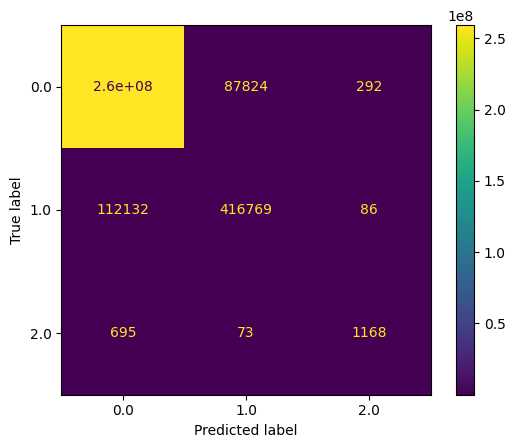

In [17]:
ConfusionMatrixDisplay.from_predictions(y_true=all_flattened_labels, y_pred=all_flattened_preds)

## Analysing specific cases:

In [18]:
sample_case_num_idx = 7  # or sample from range(len(test_ids))
sample_case_id = test_ids[sample_case_num_idx]
sample_labels_path, sample_predictions_path = get_paths(case_id=sample_case_id, labels=True, preds=True)

In [23]:
from nnunetv2.imageio.simpleitk_reader_writer import SimpleITKIO
from nnunetv2.evaluation.evaluate_predictions import compute_metrics

results = compute_metrics(
    reference_file=sample_labels_path,
    prediction_file=sample_predictions_path,
    image_reader_writer=SimpleITKIO(),
    labels_or_regions=[1, 2]
)

In [24]:
results

{'reference_file': '/home/ander/PycharmProjects/nnunet-ms-segmentation/data/nnUNet_raw_data/Dataset100_MSSEG/labelsTs/FIS_039_01.nii.gz',
 'prediction_file': '/home/ander/PycharmProjects/nnunet-ms-segmentation/nnUNet_test_results/Dataset100_MSSEG/nnUNetTrainerEarlyStopping__nnUNetPlans__3d_fullres/FIS_039_01.nii.gz',
 'metrics': {1: {'Dice': 0.8272707738588575,
   'IoU': 0.7054235158622134,
   'FP': 6439,
   'TP': 40425,
   'FN': 10442,
   'TN': 7163726,
   'n_pred': 46864,
   'n_ref': 50867},
  2: {'Dice': 0.4063745019920319,
   'IoU': 0.255,
   'FP': 33,
   'TP': 51,
   'FN': 116,
   'TN': 7220832,
   'n_pred': 84,
   'n_ref': 167}}}

In [21]:
sample_b_image, sample_fu_image = read_images(case_id=sample_case_id)
sample_labels, sample_predictions = read_labels_and_preds(case_id=sample_case_id)

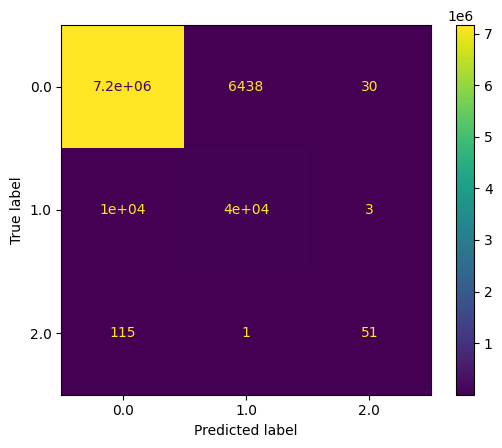

In [22]:
ConfusionMatrixDisplay.from_predictions(y_true=sample_labels.flatten(), y_pred=sample_predictions.flatten())